# ***Setting Up W&B***

In [1]:
!pip install wandb -Uq

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: goyal-shubh-07 (goyal-shubh-07-indian-institute-of-technology-jodhpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
config = {
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 10,
    'dropout_rate': 0.3
}

# ***Training and Logging***

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

### ***FashionMNIST Processing***

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [17]:
def get_data_loaders(batch_size):
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader

### ***CNN Model***

In [18]:
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(FashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### ***Training and Testing***

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [20]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [21]:
def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [22]:
def run_wandb_experiment():
    wandb.init(
        project='fashion-mnist-classification',
        config=config
    )

    train_loader, test_loader = get_data_loaders(config['batch_size'])


    model = FashionCNN(config['dropout_rate']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


    for epoch in range(config['epochs']):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })

    wandb.finish()

In [23]:
run_wandb_experiment()

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇█
val_loss,█▅▃▂▂▂▁▁▂▁
epoch,9
train_accuracy,94.26833
train_loss,0.15381
val_accuracy,92.24
val_loss,0.23423


Training completed successfully!


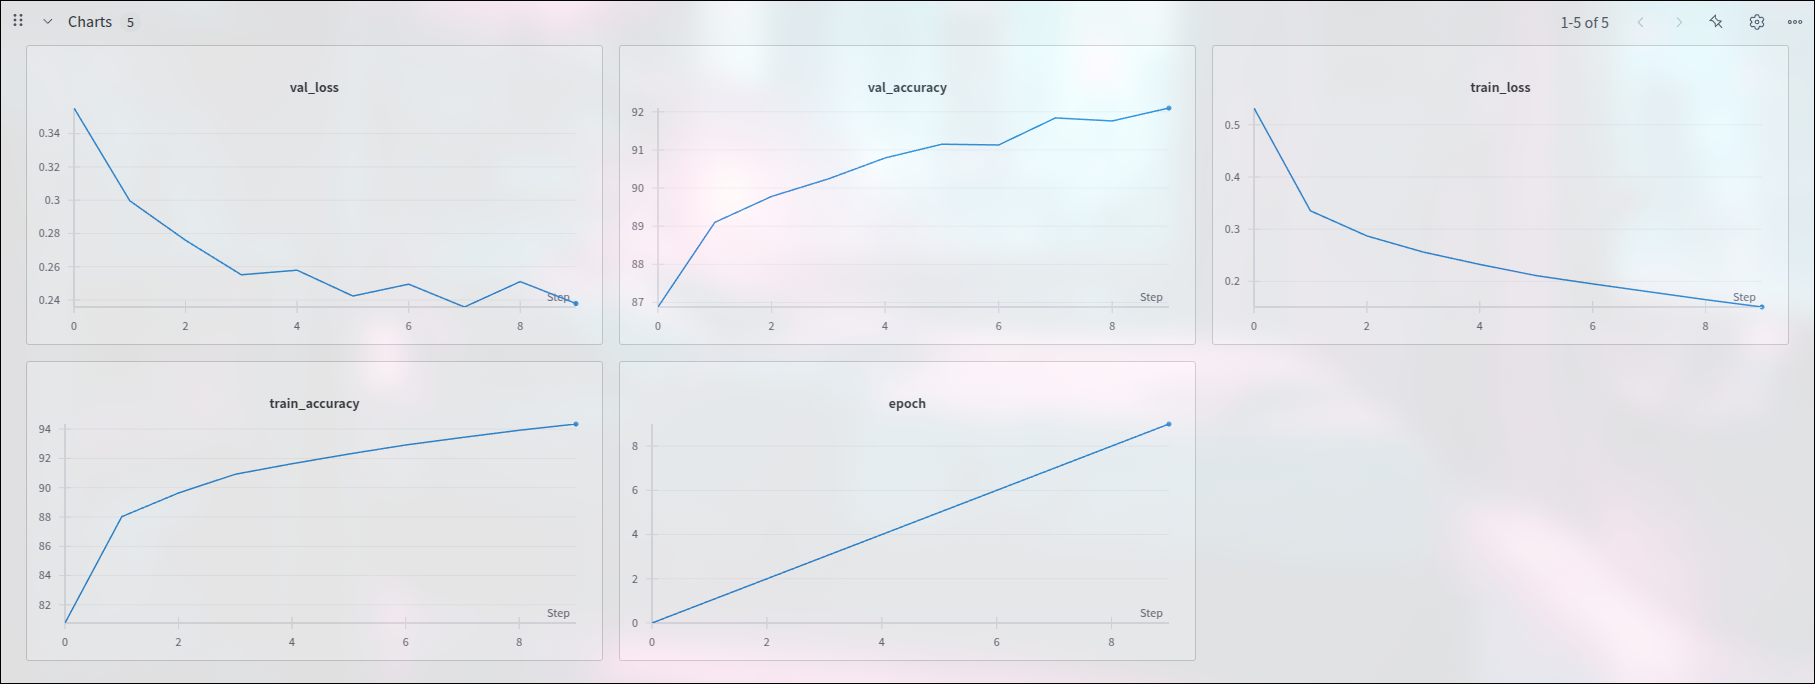

# ***Hyperparameter Optimization with W&B Sweeps***

In [24]:
def train_and_evaluate():
    wandb.init()

    config = wandb.config

    train_loader, test_loader = get_data_loaders(config.batch_size)

    model = FashionCNN(config.dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })

    return val_acc

In [25]:
sweep_configuration = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'epochs': {
            'values': [5, 10, 15]
        },
        'dropout_rate': {
            'values': [0.3, 0.5, 0.7]
        }
    }
}

In [26]:
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='fashion-mnist-classification'
)

wandb.agent(
    sweep_id,
    function=train_and_evaluate,
    count=10
)

Create sweep with ID: 7h44s87h
Sweep URL: https://wandb.ai/goyal-shubh-07-indian-institute-of-technology-jodhpur/fashion-mnist-classification/sweeps/7h44s87h


wandb: Agent Starting Run: rlo4kwcg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,9
train_accuracy,88.09833
train_loss,0.33995
val_accuracy,89.44
val_loss,0.29448


wandb: Agent Starting Run: ekqoxyyc with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▂
epoch,4
train_accuracy,72.43
train_loss,0.72686
val_accuracy,82.04
val_loss,0.50226


wandb: Agent Starting Run: igysfcik with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇███▇██
train_loss,█▃▂▂▁▁▁▂▁▁
val_accuracy,▁▅▅▇▆▇▆█▇▆
val_loss,█▄▃▂▃▂▃▁▂▃
epoch,9
train_accuracy,83.58
train_loss,0.44325
val_accuracy,84.65
val_loss,0.41516


wandb: Agent Starting Run: 65a96wok with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▄▆█
val_loss,█▅█▁▁
epoch,4
train_accuracy,86.08333
train_loss,0.37826
val_accuracy,86.85
val_loss,0.3611


wandb: Agent Starting Run: ba1cwkil with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 15
wandb: 	learning_rate: 0.001


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇████
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▅▄▇▇▇▆▇█▇▇███▇
val_loss,█▄▄▂▁▁▄▃▂▂▄▄▅▇█
epoch,14
train_accuracy,96
train_loss,0.10445
val_accuracy,91.51
val_loss,0.33153


wandb: Agent Starting Run: tvt85ypk with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▅█▄▃▇▅
val_loss,█▅▃▄▂▁▅█▃▂
epoch,9
train_accuracy,86.34333
train_loss,0.37508
val_accuracy,86.06
val_loss,0.3641


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9kz6st91 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇██
val_loss,█▅▄▃▃▃▂▂▁▁
epoch,9
train_accuracy,79.785
train_loss,0.53206
val_accuracy,87.26
val_loss,0.35241


wandb: Agent Starting Run: fm1pmw3z with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
train_accuracy,80.585
train_loss,0.54359
val_accuracy,86.7
val_loss,0.37197


wandb: Agent Starting Run: trpvak9i with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,9
train_accuracy,91.87
train_loss,0.22239
val_accuracy,91.45
val_loss,0.24303


wandb: Agent Starting Run: qxr7rxpi with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,4
train_accuracy,89.31167
train_loss,0.30238
val_accuracy,90.16
val_loss,0.26902


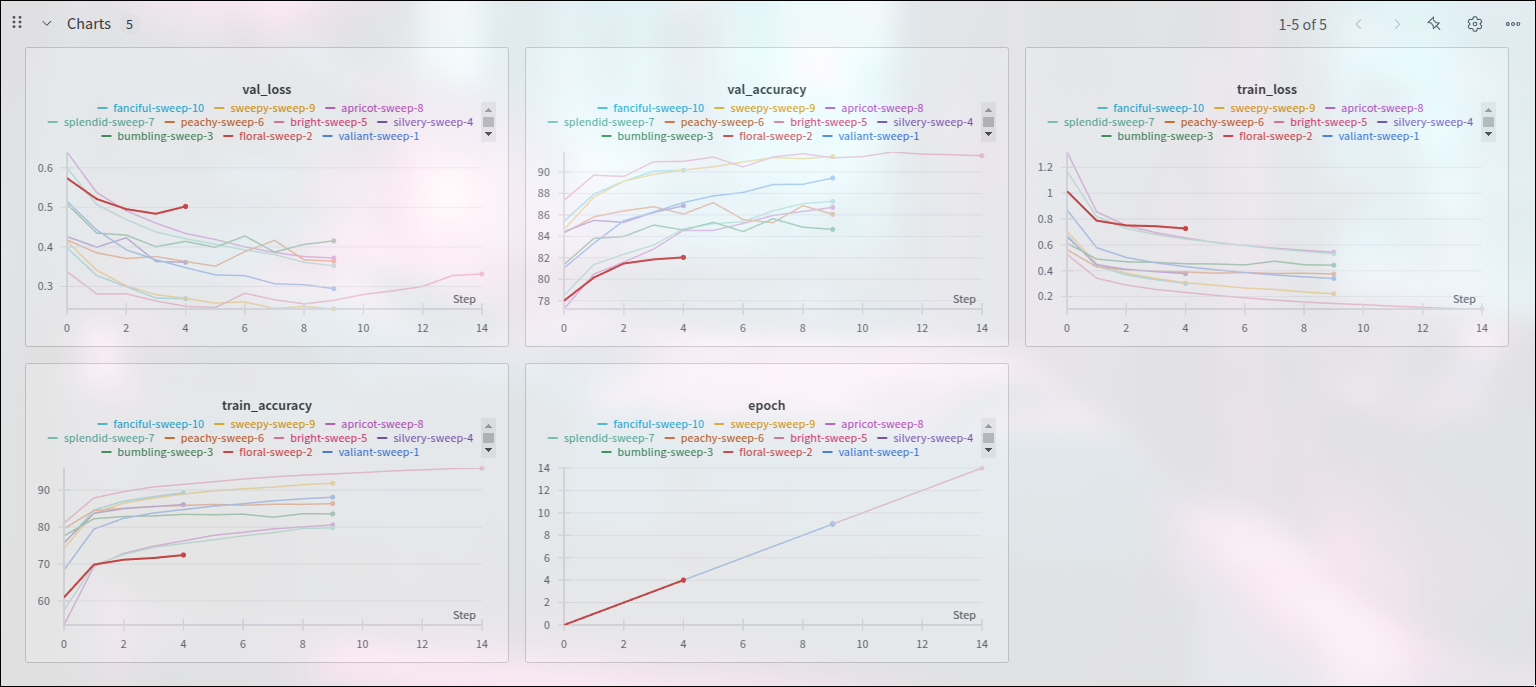

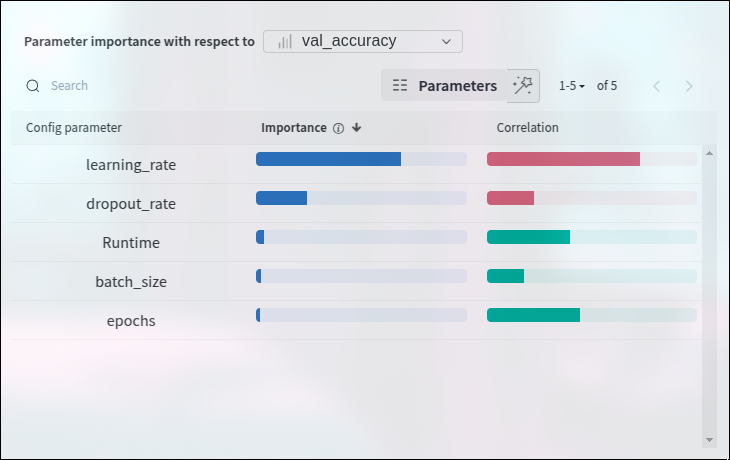

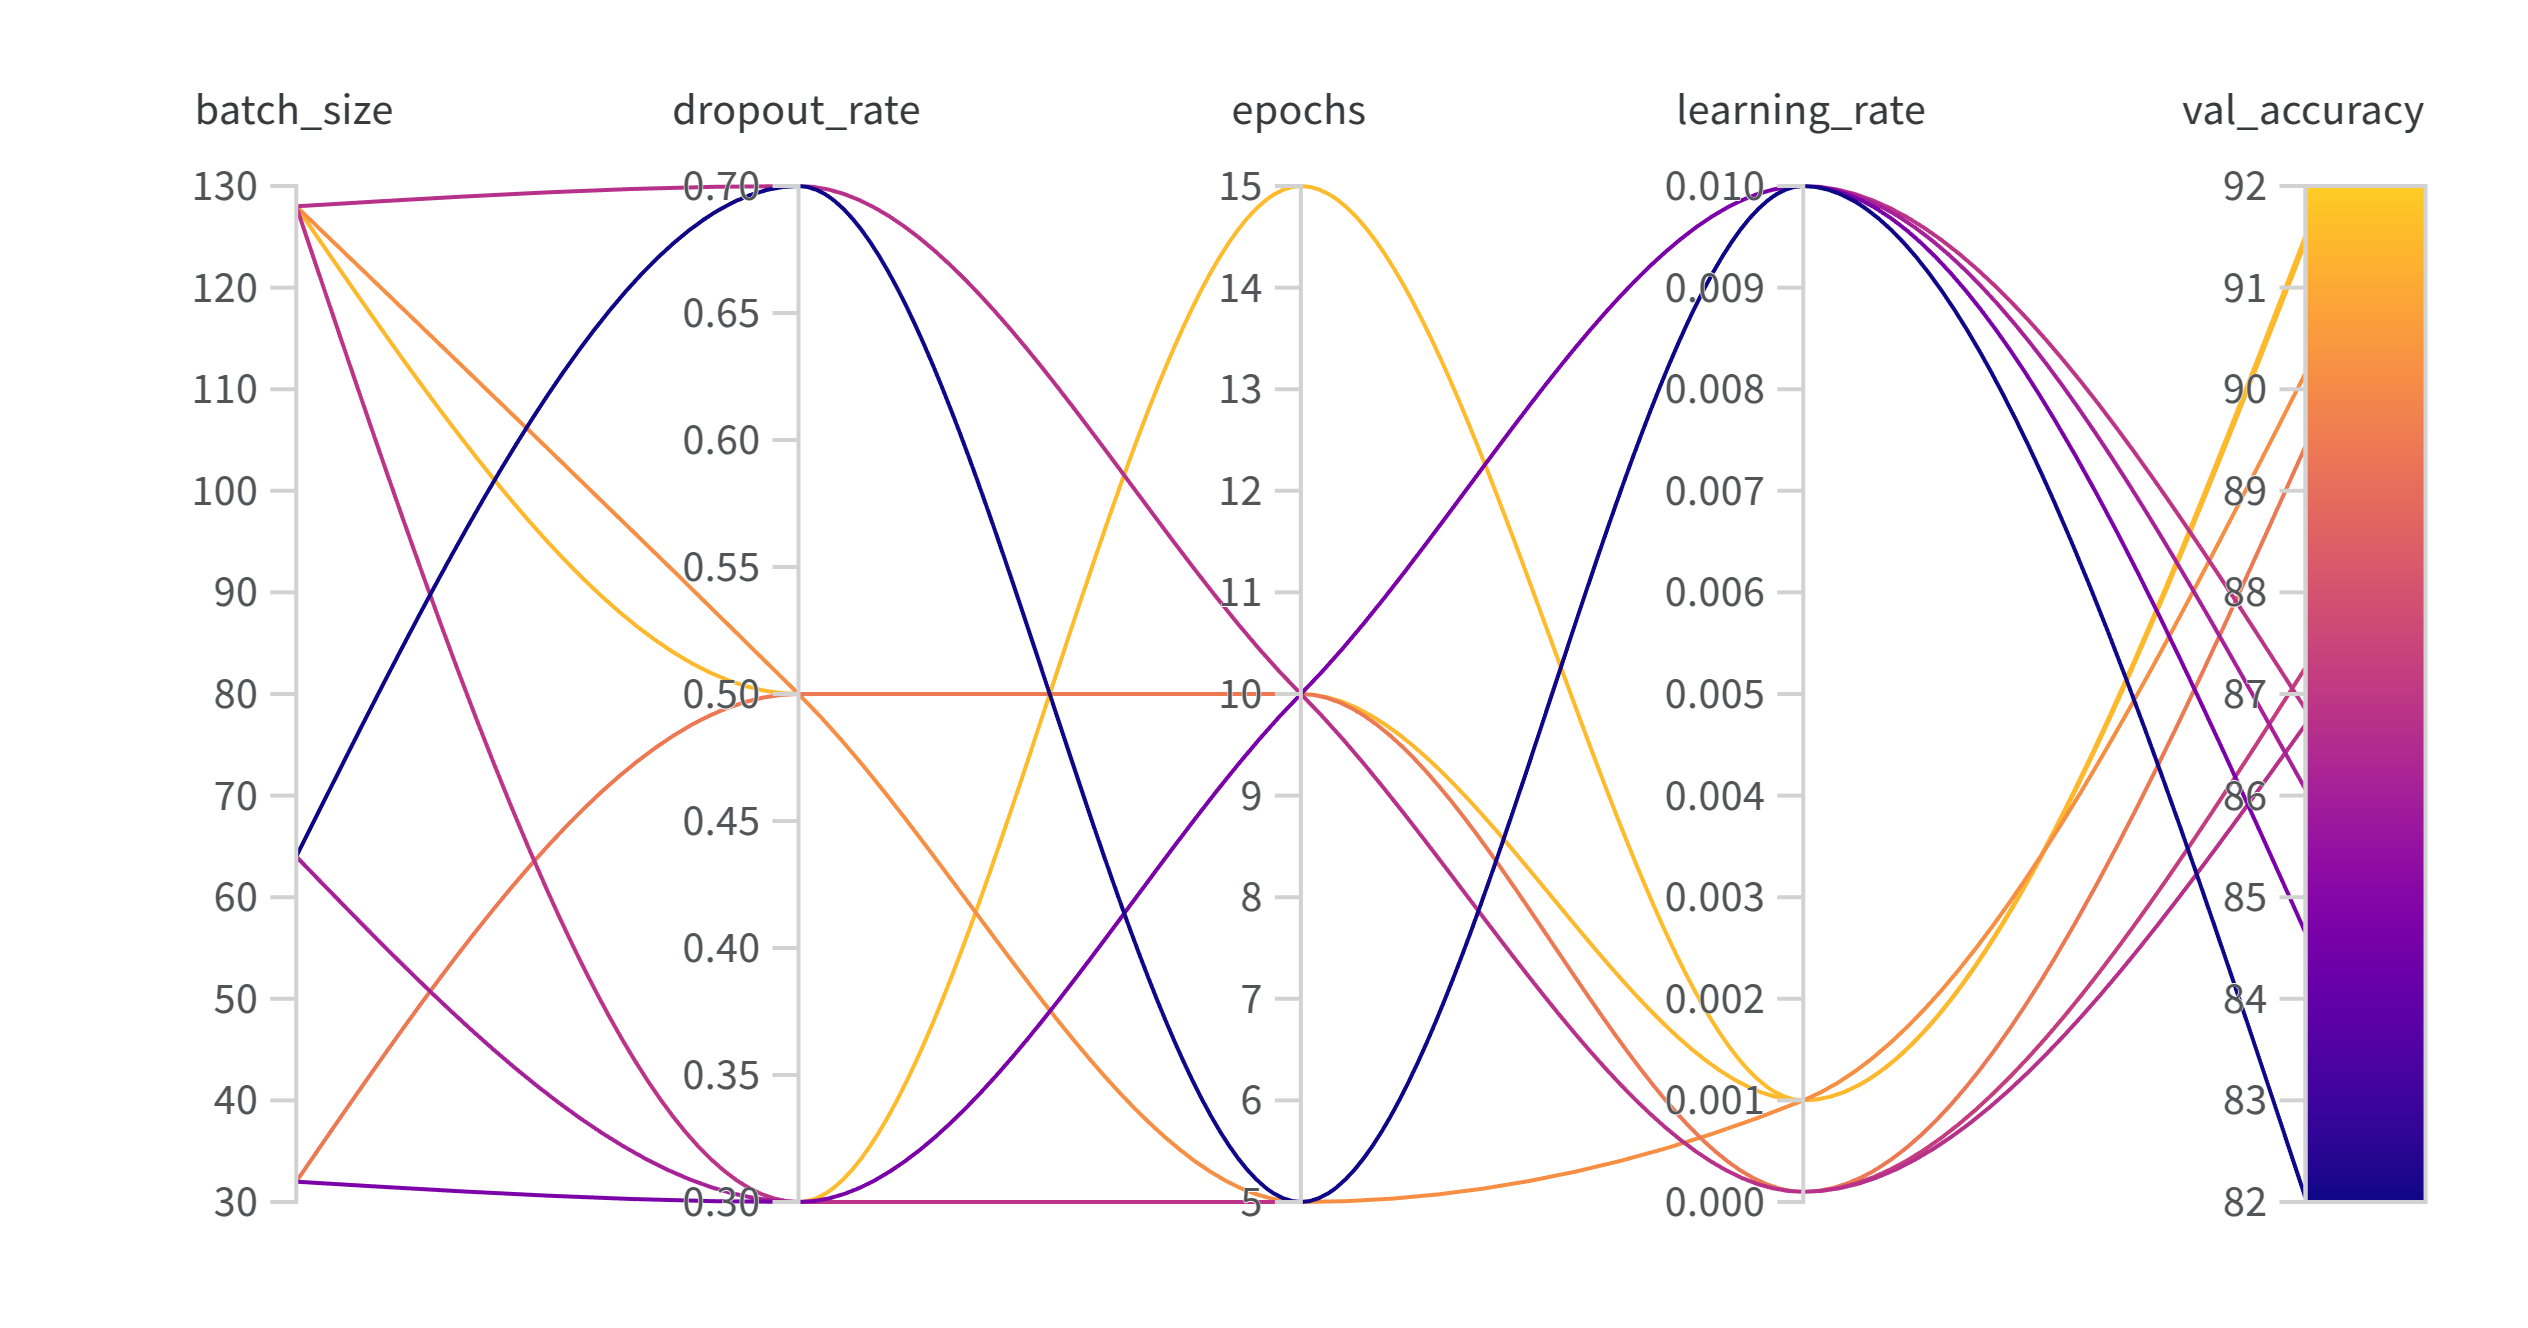